# Process Provo Corpus

In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import torch
from collections import defaultdict, Counter
import random
import math
import pickle

%matplotlib inline
%load_ext autoreload
%autoreload 2
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

## Read data

In [2]:
df_raw = pd.read_csv("../data/ProvoCorpus.csv")

In [3]:
# Rename to be similar to ZuCo
df = pd.DataFrame({
  'participant_id': df_raw['Participant_ID'],
  'text_id': df_raw['Text_ID'],
  'orig_sentence_id': df_raw['Sentence_Number'],
  'word_id': df_raw['Word_In_Sentence_Number'],
  'word': df_raw['Word'],
  'nFix': df_raw['IA_FIXATION_COUNT'],
  'FFD': df_raw['IA_FIRST_FIXATION_DURATION'],
  'GPT': df_raw['IA_REGRESSION_PATH_DURATION'],
  'TRT': df_raw['IA_DWELL_TIME'],
})
df = df.fillna(0)
df['orig_sentence_id'] = df['orig_sentence_id'].astype(int)
df['word_id'] = df['word_id'].astype(int)
df['nFix'] = df['nFix'].astype(float)
df['TRT'] = df['TRT'].astype(float)

In [4]:
# Renumber sentences ids from original (text id, sentence id) starting from 0
df = df[~((df.orig_sentence_id == 0) | (df.word_id == 0))]
id_map = {}
for _, row in df.iterrows():
  k = (row['text_id'], row['orig_sentence_id'])
  if k in id_map:
    v = id_map[k]
  else:
    v = len(id_map)
    id_map[k] = v

df['sentence_id'] = df.apply(lambda row: id_map[(row['text_id'], row['orig_sentence_id'])], axis=1)
df = df[['participant_id', 'sentence_id', 'word_id', 'word', 'nFix', 'FFD', 'GPT', 'TRT']]

## Take averages across participants

In [10]:
agg_df = df.groupby(['sentence_id', 'word_id', 'word']).mean().reset_index()
agg_df['fixProp'] = df.groupby(['sentence_id', 'word_id', 'word'])['nFix'] \
  .apply(lambda col: (col != 0).sum() / len(col)).reset_index()['nFix']

In [11]:
# Scale to have the same mean and standard deviation as ZuCo data
agg_fts = agg_df[['nFix', 'FFD', 'GPT', 'TRT', 'fixProp']]
agg_df[['nFix', 'FFD', 'GPT', 'TRT', 'fixProp']] = (agg_fts - agg_fts.mean(axis=0)) / agg_fts.std(axis=0)

agg_df['nFix'] = 15.10 + 9.42 * agg_df['nFix']
agg_df['FFD'] = 3.19 + 1.42 * agg_df['FFD']
agg_df['GPT'] = 6.35 + 5.91 * agg_df['GPT']
agg_df['TRT'] = 5.31 + 3.64 * agg_df['TRT']
agg_df['fixProp'] = 67.06 + 26.06 * agg_df['fixProp']

In [12]:
agg_df.to_csv('../data/provo.csv', index=False)

## Sanity check

In [13]:
agg_df.describe()

,sentence_id,word_id,nFix,FFD,GPT,TRT,fixProp
count,2659.000000,2659.000000,2659.000000,2659.000000,2659.000000,2659.000000,2659.000000
mean,68.980820,13.389996,15.100000,3.190000,6.350000,5.310000,67.060000
std,39.431513,9.369687,9.420000,1.420000,5.910000,3.640000,26.060000
min,0.000000,1.000000,-1.652523,0.007905,-2.928770,-0.760671,3.404076
25%,34.000000,6.000000,7.766431,2.036794,2.190136,2.384935,46.201897
50%,69.000000,12.000000,14.210978,3.335596,5.408140,4.878256,71.880589
75%,104.000000,19.000000,21.151260,4.325051,9.384267,7.589076,90.426312
max,133.000000,53.000000,65.767356,6.968714,45.079933,23.784378,106.118846


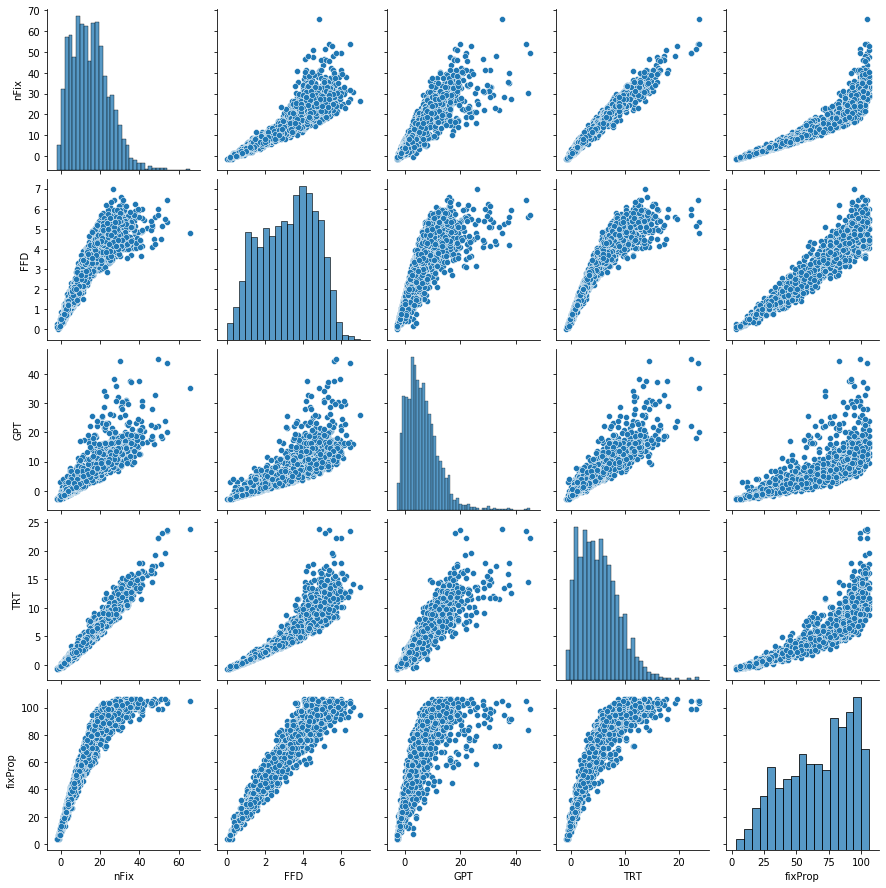

In [14]:
sns.pairplot(agg_df[['nFix', 'FFD', 'GPT', 'TRT', 'fixProp']])